# Objective: Train several models and evaluate how effectively they predict instances of fraud

I will be using data based on [this dataset from Kaggle](https://www.kaggle.com/dalpozz/creditcardfraud). If the original link no longer works, the data can also be found in the file `fraud_data.csv`
 
Each row in `fraud_data.csv` corresponds to a credit card transaction. Features include confidential variables `V1` through `V28` as well as `Amount` which is the amount of the transaction. 
 
The target is stored in the `class` column, where a value of 1 corresponds to an instance of fraud and 0 corresponds to an instance of not fraud.

In [1]:
import numpy as np
import pandas as pd

### Step 1
Import the data from `fraud_data.csv`. I determine the percentage of the observations in the dataset that are instances of fraud

*This function returns a float between 0 and 1.* 

In [3]:
def step_one():
    df = pd.read_csv('fraud_data.csv')
    bincount = np.bincount(df.Class)
    fraud = bincount[1]
    total = len(df)
    answer = fraud/total
    return fraud/total

step_one()

0.016410823768035772

In [4]:
# Use X_train, X_test, y_train, y_test for all of the following steps
from sklearn.model_selection import train_test_split

df = pd.read_csv('fraud_data.csv')

X = df.iloc[:,:-1]
y = df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

### Step 2

Using `X_train`, `X_test`, `y_train`, and `y_test` (as defined above), I train a dummy classifier that classifies everything as the majority class of the training data. I then determine the accuracy and recall of this classifier. 

*This function returns a tuple with two floats, i.e. `(accuracy score, recall score)`.*

In [5]:
def step_two():
    from sklearn.dummy import DummyClassifier
    from sklearn.metrics import recall_score, accuracy_score

    #create and fit a dummy classifer that will always predict the most frequent label in the training set
    dummy_clf = DummyClassifier(strategy = 'most_frequent').fit(X_train, y_train)

    #use the dummy classifer to predict values based of the text data
    predicted = dummy_clf.predict(X_test)

    #calculate the accuracy of the dummy classifier
    accuracy = accuracy_score(y_test, predicted)

    #calculate the recall of the dummy classifier
    recall = recall_score(y_test, predicted)
    answer = (accuracy,recall)
    return answer
step_two()

(0.9852507374631269, 0.0)

### Step 3

I use X_train, X_test, y_train, y_test (as defined above) to train a SVC classifer using the default parameters. I return the accuracy, recall, and precision of the classifier

*This function returns a tuple with three floats, i.e. `(accuracy score, recall score, precision score)`.*

In [6]:
def step_three():
    from sklearn.metrics import recall_score, precision_score, accuracy_score
    from sklearn.svm import SVC
    #create the svm classifier and train it
    svm = SVC().fit(X_train, y_train)

    #Get the SVM's output based of the text data
    predicted = svm.predict(X_test)

    #sklearn.metrics built in functions to generate related metrics
    accuracy_score = accuracy_score(y_test,predicted)
    recall_score = recall_score(y_test, predicted)
    precision_score = precision_score(y_test,predicted)
    answer = (accuracy_score,recall_score,precision_score)
    return answer
step_three()

(0.9907817109144543, 0.375, 1.0)

### Step 4

Using the SVC classifier with parameters `{'C': 1e9, 'gamma': 1e-07}`, I generate the confusion matrix when using a threshold of -220 on the decision function. I use X_test and y_test.

*This function returns a confusion matrix, a 2x2 numpy array with 4 integers.*

In [7]:
def step_four():
    from sklearn.metrics import confusion_matrix
    from sklearn.svm import SVC

    #create and train the SVC classifier with following parameters {'C': 1e9, 'gamma': 1e-07}
    clf = SVC(gamma = 1e-07, C=1e9).fit(X_train,y_train)

    #modify the prediction so that fraud is only detected if classifier score
    #is greater than -220
    prediction = clf.decision_function(X_test) > -220
    
    #return the confusion matrix
    confusion = confusion_matrix(y_test, prediction) 
    return confusion

step_four()

array([[5320,   24],
       [  14,   66]], dtype=int64)

### Step 5

I Train a logistic regression classifier with default parameters using X_train and y_train.

For the logistic regression classifier, I create a precision recall curve and a roc curve using y_test as the probability estimates for X_test (probability it is fraud).

Looking at the precision recall curve, I determine what the recall is when the precision is `0.75`?

Looking at the roc curve, I determine what the true positive rate is when the false positive rate is `0.16`?

*This function returns a tuple with two floats, i.e. `(recall, true positive rate)`.*

In [8]:
def step_five():
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import precision_recall_curve
    from sklearn.metrics import roc_curve, auc
    
    #create the logistic regression
    lr = LogisticRegression()
    
    #get the confidence of predictions
    y_proba_lr = lr.fit(X_train, y_train).predict_proba(X_test)
    
    #get the classifier scores of the logistic regression
    y_scores_lr = lr.fit(X_train, y_train).decision_function(X_test)
    
    #get the precision and recall 
    precision, recall, thresholds = precision_recall_curve(y_test, y_scores_lr)
    
    #get the false positive rate and the true positive rate from the ROC curve
    fpr_lr, tpr_lr, _ = roc_curve(y_test, y_scores_lr)
    
    #find the corresponding recall and true positive rate
    rec = float(recall[np.where(precision==0.75)])
    tpr = float(tpr_lr[np.where((fpr_lr >= 0.159) & (fpr_lr <= 0.161))][0])
    answer = (rec,tpr)
    return answer

step_five()

(0.825, 0.9375)

### Step 6

I perform a grid search over the parameters listed below for a Logistic Regression classifier. I use recall for scoring and the default 3-fold cross validation.

`'penalty': ['l1', 'l2']`

`'C':[0.01, 0.1, 1, 10, 100]`

From `.cv_results_`, I create an array of the mean test scores of each parameter combination. 

i.e.

|      	| `l1` 	| `l2` 	|
|:----:	|----	|----	|
| **`0.01`** 	|    ?	|   ? 	|
| **`0.1`**  	|    ?	|   ? 	|
| **`1`**    	|    ?	|   ? 	|
| **`10`**   	|    ?	|   ? 	|
| **`100`**   	|    ?	|   ? 	|

<br>

*This function returns a 5 by 2 numpy array with 10 floats.* 

In [9]:
def step_six():    
    from sklearn.model_selection import GridSearchCV
    from sklearn.linear_model import LogisticRegression

    #create and train the logistic regression
    lr = LogisticRegression().fit(X_train, y_train)
    
    #create the dictionary that gridsearch will use as inputs to do it's testing
    grid_values = {'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10, 100]}
    
    #perform the gridsearch on the logistic regression using the grid_values as inputs and using recall
    grid_clf_rec = GridSearchCV(lr, param_grid = grid_values, scoring = 'recall')
    grid_clf_rec.fit(X_train, y_train)
    
    #get the results of the grid search and but it to a numpy array
    answer = np.array(grid_clf_rec.cv_results_['mean_test_score']).reshape(5,2)
    
    return answer
step_six()

array([[0.66666667, 0.76086957],
       [0.80072464, 0.80434783],
       [0.8115942 , 0.8115942 ],
       [0.80797101, 0.8115942 ],
       [0.80797101, 0.8115942 ]])

<IPython.core.display.Javascript object>


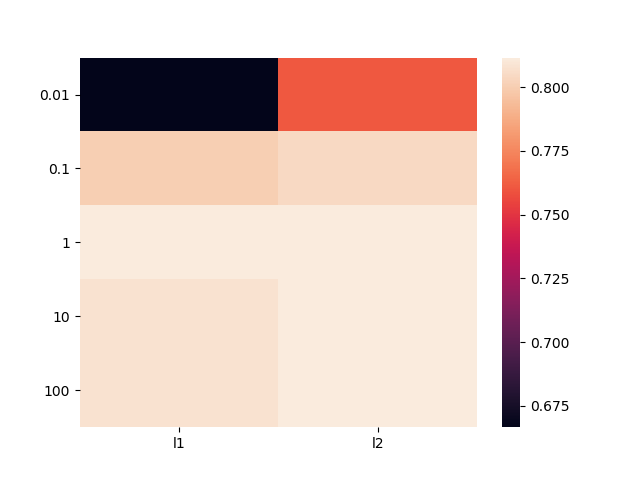

In [11]:
# I Use the following function to visualize results from the grid search
def GridSearch_Heatmap(scores):
    %matplotlib notebook
    import seaborn as sns
    import matplotlib.pyplot as plt
    plt.figure()
    sns.heatmap(scores.reshape(5,2), xticklabels=['l1','l2'], yticklabels=[0.01, 0.1, 1, 10, 100])
    plt.yticks(rotation=0);

GridSearch_Heatmap(step_six())